In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from glob import glob
import os

# NetCDF
from netCDF4 import Dataset, num2date, date2num

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors, cbook
import seaborn as sns
import cmocean as cmocn  # comment out if unused

# Machine Learning
from sklearn.cluster import DBSCAN, OPTICS, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             silhouette_score,
                             pairwise_distances)
from imblearn.over_sampling import SMOTE

# Scipy
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d

# Parallelism
from joblib import Parallel, delayed

# Tensorflow
import tensorflow as tf

# Jupyter Magic
%matplotlib inline

2025-08-03 15:52:57.050534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 15:52:57.061783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754250777.074484  399087 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754250777.078296  399087 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754250777.087856  399087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
folderLoc ='/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/extractedGZ/WINDS/'
fileList = glob(folderLoc + '*_xrr_COARE3p5_2000_withRAIN_2hrMeanVar.nc')

In [3]:
# count = 0
# for fname in fileList:
#     print(fname.lstrip(folderLoc).rstrip('_xrr_COARE3p5_2000_withRAIN_2hrMeanVar.nc'))
#     #_xrr_COARE3p5_2000_2hrMeanVar.nc
#     ds = xr.open_dataset(fname)
#     ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
#     selectLabels = ['mean_WVEL', 'mean_WSPD', 'std_WSPD', 
#                     'std_cosWDIR' , 'std_sinWDIR', 
#                     'mean_SST', 'std_SST', 
#                     'mean_AIRT', 'std_AIRT',
#                     'mean_SST - AIRT', 'std_SST - AIRT',
#                     'mean_RELH', 'std_RELH',
#                     'mean_RAIN', 'RAIN']
#     subDS = ds[selectLabels]
#     selectMask = ~np.isnan(subDS['mean_WVEL'].to_numpy())
#     subDS = subDS.isel(TIME=selectMask)
#     stdLabels = ['std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']
#     for label in stdLabels:
#         mask = np.isnan(subDS[label].to_numpy())
#         #print(label, np.sum(mask))
#         subDS[label] = xr.where(mask, 0.0, subDS[label])
#     data = subDS.to_dataframe()
#     if count == 0:
#         allDF = data
#     else:
#         allDF = pd.concat([allDF, data])
#     ds.close()
#     count+= 1
            

In [4]:
#allDF

In [5]:
#allDF.to_csv('allData.csv', index=False)

In [6]:
allDF = pd.read_csv('allData.csv')

In [7]:
len(allDF)

12710025

In [8]:
# data = allDF
# data['RAIN_LABEL'] = data['RAIN'].apply(lambda x: 1 if x > 10 else 0)

# # Features to use for classification
# features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']

# # Split the dataset into features (X) and target (y)
# X = data[features]
# y = data['RAIN_LABEL']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train a RandomForest Classifier
# classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
# classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test)

# # Evaluate the classifier performance
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [26]:
data = allDF
data['RAIN_LABEL'] = data['mean_RAIN'].apply(lambda x: 1 if x > 1 else 0)

features = ['mean_WSPD', 'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH', 'std_WSPD', 'std_cosWDIR', 'std_sinWDIR', 'std_SST', 'std_AIRT', 'std_SST - AIRT', 'std_RELH']

X = data[features]

# Compute correlation matrix
corr_matrix = X.corr()#.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold (e.g., 0.9)
threshold = 0.9
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

# Drop them
df_reduced = X.drop(columns=to_drop)

print(f"Removed {len(to_drop)} features: {to_drop}")

features = list(df_reduced.columns)
features, len(features)

Removed 2 features: ['mean_AIRT', 'std_SST - AIRT']


(['mean_WSPD',
  'mean_SST',
  'mean_SST - AIRT',
  'mean_RELH',
  'std_WSPD',
  'std_cosWDIR',
  'std_sinWDIR',
  'std_SST',
  'std_AIRT',
  'std_RELH'],
 10)

In [27]:
# Split the dataset into features (X) and target (y)
X = data[features]
y = data['RAIN_LABEL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Initialize and train a RandomForest Classifier
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
# classifier = RandomForestClassifier(n_estimators=500,
#                                     max_depth=20,
#                                     min_samples_leaf= 20,
#                                     min_samples_split= 20,
#                                     max_features=0.5,  
#                                     bootstrap=True,
#                                     random_state=42,
#                                     class_weight='balanced',
#                                     n_jobs=-1)
classifier.fit(X_train_bal, y_train_bal)

# Make predictions on the test set and unbalanced train set
y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   9884410
           1       1.00      1.00      1.00    283610

    accuracy                           1.00  10168020
   macro avg       1.00      1.00      1.00  10168020
weighted avg       1.00      1.00      1.00  10168020

Accuracy: 0.9995385532286521

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2471093
           1       0.99      0.99      0.99     70912

    accuracy                           1.00   2542005
   macro avg       0.99      1.00      1.00   2542005
weighted avg       1.00      1.00      1.00   2542005



In [28]:
y_train_bal_pred = classifier.predict(X_train_bal)
train_acc = accuracy_score(y_train_bal, y_train_bal_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
#If train accuracy ≫ test accuracy → Overfitting

Train Accuracy: 1.0000
Test Accuracy: 0.9995


In [29]:
# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_train_bal, y_train_bal_pred))
print("\nClassification Report:\n", classification_report(y_train_bal, y_train_bal_pred))

# Evaluate the classifier performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   9884410
           1       1.00      1.00      1.00   9884410

    accuracy                           1.00  19768820
   macro avg       1.00      1.00      1.00  19768820
weighted avg       1.00      1.00      1.00  19768820

Accuracy: 0.9995385532286521

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2471093
           1       0.99      0.99      0.99     70912

    accuracy                           1.00   2542005
   macro avg       0.99      1.00      1.00   2542005
weighted avg       1.00      1.00      1.00   2542005



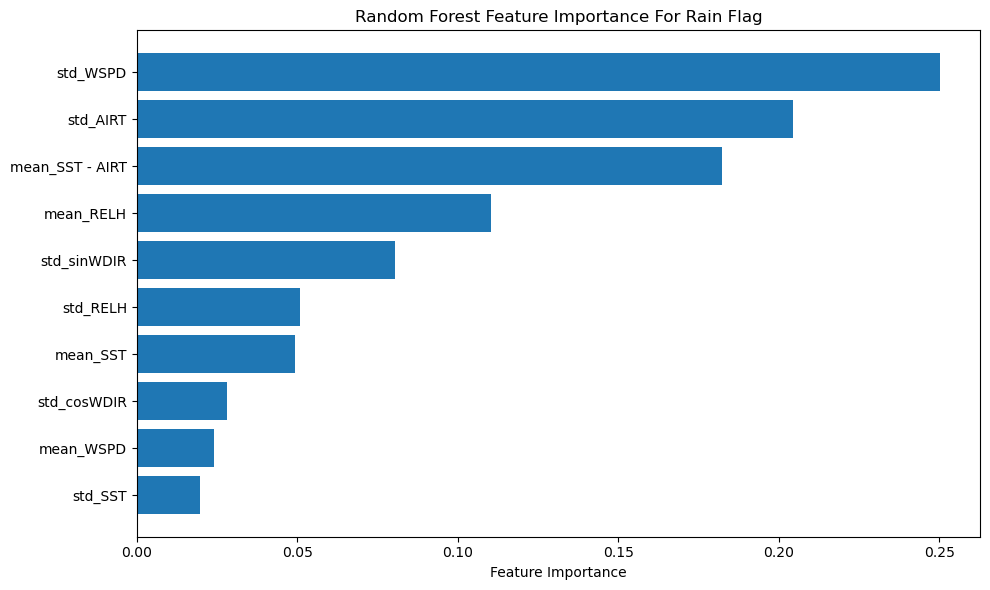

In [30]:
importances = classifier.feature_importances_
features = X_train.columns  # Or supply your feature names list

# Replace underscores with spaces in feature names
pretty_features = [f.replace('_', ' ') for f in features]
pretty_features = [f.replace('sinWDIR', 'sin(WDIR)') for f in pretty_features]
pretty_features = [f.replace('cosWDIR', 'cos(WDIR)') for f in pretty_features]
    

# Create a DataFrame for better plotting
feat_imp_df = pd.DataFrame({'Feature': features, #pretty_features, 
                            'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance For Rain Flag')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('RainFlagRandomforestFeatureImportance.pdf', dpi=100)

In [31]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=3,  # 3-fold cross-validation
#     scoring='f1_macro',  # Balanced F1 score across classes
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

In [32]:

# train_acc = accuracy_score(y_train, best_model.predict(X_train))
# test_acc = accuracy_score(y_test, y_pred)

# print(f"Train Accuracy: {train_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")
# #If train accuracy ≫ test accuracy → Overfitting

In [33]:
falsePos = np.logical_and(y_test ==0, y_pred == 1)
falseNeg = np.logical_and(y_test ==1, y_pred == 0)

In [34]:
np.sum(falsePos)

np.int64(798)

In [35]:
np.sum(falseNeg)

np.int64(375)

In [36]:
len(y_test)

2542005

In [37]:
(np.sum(falsePos) + np.sum(falseNeg))/2542005*100

np.float64(0.0461446771347814)

In [38]:
import joblib
# from sklearn.ensemble import RandomForestClassifier
# # create RF
# rf = RandomForestClassifier()
# # fit on some data
# rf.fit(X, y)

# save
joblib.dump(classifier, "random_forest_rainDetection.joblib")

# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

['random_forest_rainDetection.joblib']

In [39]:
2273/(145982 + 2273) * 100

1.5331692017132643

In [40]:
145982 + 2273

148255